# Resnet18

In [8]:
import torch
import torchvision

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn, optim

import matplotlib.pyplot as plt
from devinterp.slt.sampler import estimate_rlct

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

In [9]:
# Transform to imagenet format
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.244, 0.225]
    )
])

trainset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.888113334774971, Test Loss: 0.9713506177067757, Train Acc: 0.70096, Test Acc: 0.6654


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.6606323186840329, Test Loss: 0.7929640173912048, Train Acc: 0.78258, Test Acc: 0.7288


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.5129201401557241, Test Loss: 0.7010601758956909, Train Acc: 0.83982, Test Acc: 0.7646


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.4086993622536562, Test Loss: 0.6613175600767136, Train Acc: 0.88434, Test Acc: 0.7837


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.34511339603638164, Test Loss: 0.6455174326896668, Train Acc: 0.90826, Test Acc: 0.7937


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.30372839177749594, Test Loss: 0.6509892895817757, Train Acc: 0.92874, Test Acc: 0.8002


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.2881906487199725, Test Loss: 0.6535788863897324, Train Acc: 0.93868, Test Acc: 0.8066


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.39469579744095706, Test Loss: 0.7281474187970162, Train Acc: 0.9039, Test Acc: 0.7849


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.4070485550530103, Test Loss: 0.7181157931685448, Train Acc: 0.91022, Test Acc: 0.7926


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.5539002505188085, Test Loss: 0.8309764742851258, Train Acc: 0.86608, Test Acc: 0.7611


Epoch 10:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.6280124372973734, Test Loss: 0.8555533811450005, Train Acc: 0.8452, Test Acc: 0.7564


Epoch 11:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.5837528147563642, Test Loss: 0.8226859658956528, Train Acc: 0.86492, Test Acc: 0.7743


Epoch 12:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.5731909025688561, Test Loss: 0.8219444364309311, Train Acc: 0.88398, Test Acc: 0.7854


Epoch 13:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.6814905274279264, Test Loss: 0.9153212800621986, Train Acc: 0.84592, Test Acc: 0.7495


Epoch 14:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 0.6643666299630184, Test Loss: 0.9022111386060715, Train Acc: 0.85664, Test Acc: 0.7572


Epoch 15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 15, Train Loss: 0.7370796930425021, Test Loss: 0.9739642381668091, Train Acc: 0.82492, Test Acc: 0.7326


Epoch 16:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 0.699111808319481, Test Loss: 0.9310917690396309, Train Acc: 0.84362, Test Acc: 0.7432


Epoch 17:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 0.7820236390950729, Test Loss: 1.010369436442852, Train Acc: 0.80904, Test Acc: 0.707


Epoch 18:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 0.7437553652087037, Test Loss: 0.9736535862088204, Train Acc: 0.82632, Test Acc: 0.7294


Epoch 19:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 0.7853400497412195, Test Loss: 1.0304467111825943, Train Acc: 0.7957, Test Acc: 0.6985


Epoch 20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 20, Train Loss: 0.6306938617205133, Test Loss: 0.89817765802145, Train Acc: 0.85844, Test Acc: 0.7469


Epoch 21:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 21, Train Loss: 0.7123536650015383, Test Loss: 0.9735528573393821, Train Acc: 0.82076, Test Acc: 0.7181


Epoch 22:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 22, Train Loss: 0.5804997706899837, Test Loss: 0.8612477630376816, Train Acc: 0.88034, Test Acc: 0.7632


Epoch 23:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 23, Train Loss: 0.637134736897994, Test Loss: 0.9299059510231018, Train Acc: 0.85602, Test Acc: 0.7364


Epoch 24:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 24, Train Loss: 0.5424889452299293, Test Loss: 0.8573417425155639, Train Acc: 0.89084, Test Acc: 0.7643


Epoch 25:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 25, Train Loss: 0.6187779605388641, Test Loss: 0.9196220204234123, Train Acc: 0.86268, Test Acc: 0.7394


Epoch 26:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 26, Train Loss: 0.6667416247786307, Test Loss: 0.9588100150227546, Train Acc: 0.84418, Test Acc: 0.7245


Epoch 27:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 27, Train Loss: 0.5629360370185911, Test Loss: 0.8859110683202743, Train Acc: 0.88498, Test Acc: 0.755


Epoch 28:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 28, Train Loss: 0.5257944501176173, Test Loss: 0.8530347168445587, Train Acc: 0.90084, Test Acc: 0.7605


Epoch 29:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 29, Train Loss: 0.5380049387411195, Test Loss: 0.8568138808012009, Train Acc: 0.89524, Test Acc: 0.7619


Epoch 30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 30, Train Loss: 0.6415267246110099, Test Loss: 0.946583217382431, Train Acc: 0.85468, Test Acc: 0.7301


Epoch 31:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 31, Train Loss: 0.5321090694288818, Test Loss: 0.8720061033964157, Train Acc: 0.8916, Test Acc: 0.7546


Epoch 32:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 32, Train Loss: 0.5480156458762228, Test Loss: 0.8960198283195495, Train Acc: 0.88658, Test Acc: 0.7461


Epoch 33:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 33, Train Loss: 0.6440136973955193, Test Loss: 0.9655255898833275, Train Acc: 0.84862, Test Acc: 0.7229


Epoch 34:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 34, Train Loss: 0.5266994765522529, Test Loss: 0.8783701792359352, Train Acc: 0.8958, Test Acc: 0.754


Epoch 35:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 35, Train Loss: 0.6200579845783661, Test Loss: 0.9734752103686333, Train Acc: 0.86374, Test Acc: 0.7201


Epoch 36:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 36, Train Loss: 0.5655891192810876, Test Loss: 0.911807632446289, Train Acc: 0.87778, Test Acc: 0.7389


Epoch 37:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 37, Train Loss: 0.5246061243268908, Test Loss: 0.8939834699034691, Train Acc: 0.89318, Test Acc: 0.756


Epoch 38:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 38, Train Loss: 0.5126333677647065, Test Loss: 0.8720633178949356, Train Acc: 0.89898, Test Acc: 0.7571


Epoch 39:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 39, Train Loss: 0.5086173144530277, Test Loss: 0.8921100229024888, Train Acc: 0.89348, Test Acc: 0.7465


Epoch 40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 40, Train Loss: 0.48590303638151716, Test Loss: 0.8588099092245102, Train Acc: 0.91042, Test Acc: 0.7614


Epoch 41:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 41, Train Loss: 0.5804538760258227, Test Loss: 0.9307302251458168, Train Acc: 0.87194, Test Acc: 0.7348


Epoch 42:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 42, Train Loss: 0.5775435813227479, Test Loss: 0.9360417902469635, Train Acc: 0.87314, Test Acc: 0.7352


Epoch 43:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 43, Train Loss: 0.5429633839093909, Test Loss: 0.9071450501680374, Train Acc: 0.8876, Test Acc: 0.7394


Epoch 44:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 44, Train Loss: 0.5362183374105668, Test Loss: 0.9085222572088242, Train Acc: 0.897, Test Acc: 0.748


Epoch 45:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 45, Train Loss: 0.5094525026423591, Test Loss: 0.882960356771946, Train Acc: 0.90836, Test Acc: 0.7592


Epoch 46:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 46, Train Loss: 0.6120357552961427, Test Loss: 0.9558088406920433, Train Acc: 0.85426, Test Acc: 0.725


Epoch 47:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 47, Train Loss: 0.5832636585953285, Test Loss: 0.9501049011945725, Train Acc: 0.8756, Test Acc: 0.7298


Epoch 48:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 48, Train Loss: 0.5656706099303401, Test Loss: 0.9446751669049263, Train Acc: 0.87912, Test Acc: 0.7292


Epoch 49:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 49, Train Loss: 0.5552686255197136, Test Loss: 0.9373672813177109, Train Acc: 0.87988, Test Acc: 0.7357


Epoch 50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 50, Train Loss: 0.5263808549058681, Test Loss: 0.8991682544350624, Train Acc: 0.88818, Test Acc: 0.7429


Epoch 51:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 51, Train Loss: 0.5145805844542931, Test Loss: 0.8874277800321579, Train Acc: 0.89606, Test Acc: 0.7505


Epoch 52:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 52, Train Loss: 0.5057314065646152, Test Loss: 0.8944668620824814, Train Acc: 0.89506, Test Acc: 0.7434


Epoch 53:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 53, Train Loss: 0.5835581896256428, Test Loss: 0.9571239516139031, Train Acc: 0.87122, Test Acc: 0.7263


Epoch 54:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 54, Train Loss: 0.5839407107963854, Test Loss: 0.9617868527770043, Train Acc: 0.86842, Test Acc: 0.7239


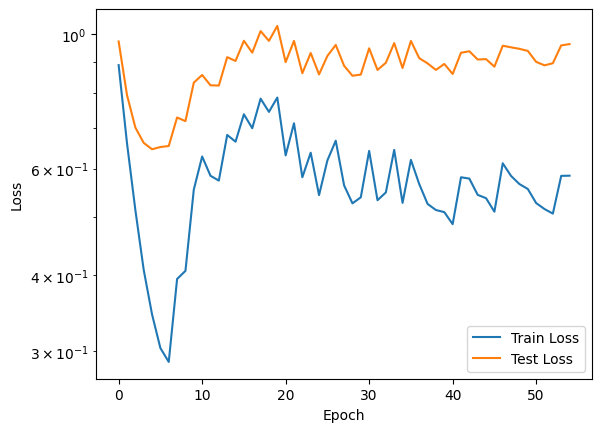

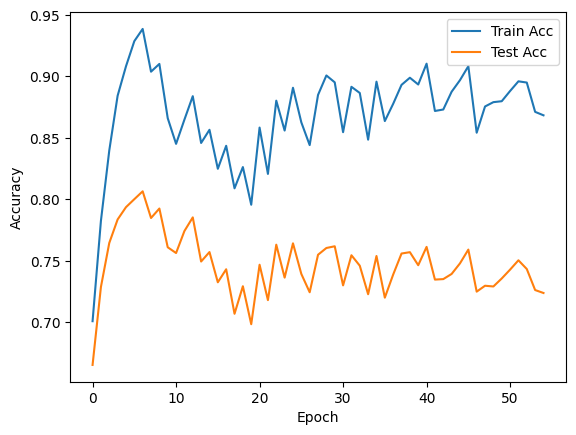

In [13]:
from tqdm.notebook import trange, tqdm

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

def finetune(model, trainloader, testloader, lr=0.01, momentum=0.9, epochs=None, epsilon=1e-4, weight_decay=0.):
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []
    
    epoch = 0
    prev_train_loss = float('inf')
    
    while True:
        # Train
        model.train()
        epoch_loss = 0.0
        for x, y in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()
        
        # Eval on training set
        model.eval()
        with torch.no_grad():
            total_train_loss = 0
            total_train_correct = 0

            for x, y in trainloader:
                x, y = x.to(device), y.to(device)
                output = model(x)

                # print(x.shape, y.shape, output.shape, output, y)
                loss = loss_fn(output, y)
                total_train_loss += loss.item()
                total_train_correct += (output.max(dim=1).indices == y).sum().item() # argmax doesn't work on MPS

            avg_train_loss = total_train_loss / len(trainloader)
            avg_train_acc = total_train_correct / len(trainset)
            train_loss_history.append(avg_train_loss)
            train_acc_history.append(avg_train_acc)
            
            # Eval on test set
            total_test_loss = 0
            total_test_correct = 0

            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = loss_fn(output, y)
                total_test_loss += loss.item()
                total_test_correct += (output.max(dim=1).indices == y).sum().item()
            
            avg_test_loss = total_test_loss / len(testloader)
            avg_test_acc = total_test_correct / len(testset)
            test_loss_history.append(avg_test_loss)
            test_acc_history.append(avg_test_acc)
        
            print(f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Train Acc: {avg_train_acc}, Test Acc: {avg_test_acc}")
        
        # Check for convergence
        if epsilon and abs(prev_train_loss - avg_train_loss) < epsilon:
            break
        
        if epochs is not None and epoch >= epochs - 1:
            break
        
        prev_train_loss = avg_train_loss
        epoch += 1
    
    # Plotting
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

    plt.plot(train_acc_history, label='Train Acc')
    plt.plot(test_acc_history, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

finetune(model, trainloader, testloader, lr=0.001, weight_decay=0.1, epsilon=0.001)

In [ ]:
for i in range(10):
    rlct = estimate_rlct(model, dataloader, nn.CrossEntropyLoss(), step='sgld', num_draws=10, num_chains=5, num_burnin_steps=0, num_steps_bw_draws=1, cores=None, seed=None, pbar=True, baseline='init', device=device)
    print(f"Estimate {i}:", rlct)

Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


Estimate 0: 20618.3155769216


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Estimate 1: 20670.238494501522


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s]


Estimate 2: 20496.632707999845


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.41it/s]


Estimate 3: 20708.223293329367


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s]


Estimate 4: 21139.081171217716


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 14.92it/s]


Estimate 5: 21799.607447388487


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s]


Estimate 6: 21293.165070258412


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


Estimate 7: 21638.908227683212


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s]


Estimate 8: 21204.354273595836


Chain 4: 100%|██████████| 10/10 [00:00<00:00, 16.21it/s]

Estimate 9: 21375.215056744957


In [ ]:
import os

rlcts = []
resnet_depths = [18, 34, 50, 101, 152]

for num_layers in resnet_depths:
    print("-" * 20 + f" ResNet{num_layers} " + "-" * 20)
    model_name = f"resnet{num_layers}"
    model = getattr(torchvision.models, model_name)(pretrained=True).to(device)

    checkpoint_name = f"../checkpoints/resnet-finetuned-cifar/{model_name}.pt"
    
    if os.path.exists(checkpoint_name):
        print("Loading from checkpoint")
        model.load_state_dict(torch.load(checkpoint_name))
    else:
        finetune(model)
        torch.save(model.state_dict(), checkpoint_name)

    _rlcts = []

    for i in range(3):
        _rlct = estimate_rlct(model, dataloader, nn.CrossEntropyLoss(), step='sgld', num_draws=100, num_chains=3, num_burnin_steps=0, num_steps_bw_draws=1, optimizer_kwargs={"elasticity": 100}, cores=None, seed=None, pbar=True, baseline='init', device=device)
        _rlcts.append(_rlct)
        print(_rlct)

    rlcts.append(_rlcts)


-------------------- ResNet18 --------------------


/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:07<00:00, 13.84it/s]


27880.18221959393


Chain 2: 100%|██████████| 100/100 [00:07<00:00, 13.92it/s]


29073.924645010513


Chain 2: 100%|██████████| 100/100 [00:07<00:00, 13.89it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


27904.688433399522
-------------------- ResNet34 --------------------
Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:11<00:00,  8.82it/s]


23122.454215606544


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


23460.14748207692


Chain 2: 100%|██████████| 100/100 [00:10<00:00,  9.26it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


23565.34652797531
-------------------- ResNet50 --------------------
Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


24445.212702964436


Chain 2: 100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


24496.579451165526


Chain 2: 100%|██████████| 100/100 [00:18<00:00,  5.36it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


23823.437147975714
-------------------- ResNet101 --------------------
Loading from checkpoint


Chain 2: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


14748.063076120457


Chain 2: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


14579.129788372586


Chain 2: 100%|██████████| 100/100 [00:29<00:00,  3.40it/s]
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Jesse/Projects/devinterp/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


15513.548725992572
-------------------- ResNet152 --------------------


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/Jesse/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

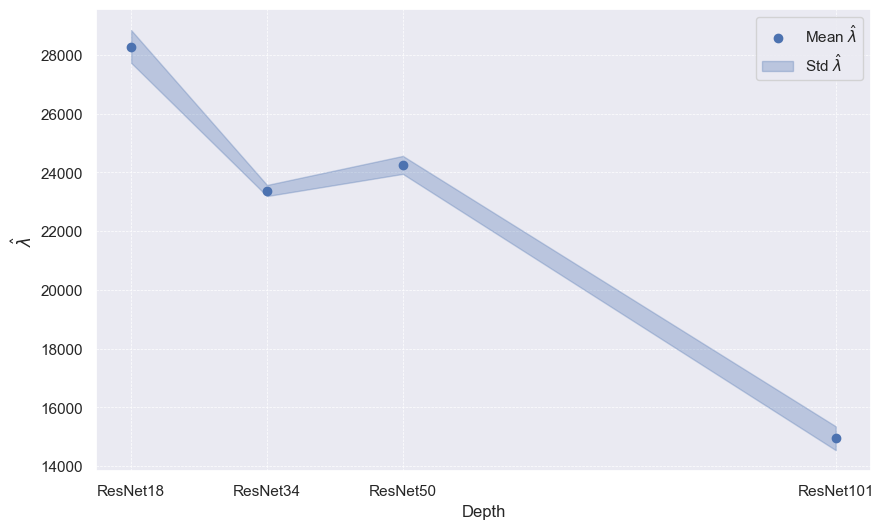

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

blue = sns.color_palette()[0]

resnet_depths = [18, 34, 50, 101]

# Names for the different ResNet architectures
arch_names = ["ResNet18", "ResNet34", "ResNet50", "ResNet101"] #, "ResNet152"]

# Calculate means and standard deviations
means = [np.mean(_rlcts) for _rlcts in rlcts]
stds = [np.std(_rlcts) for _rlcts in rlcts]

# Calculate error bounds
lower_bounds = [mean - std for mean, std in zip(means, stds)]
upper_bounds = [mean + std for mean, std in zip(means, stds)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the scatter points for the means
plt.scatter(resnet_depths, means, color=blue, label=r'Mean $\hat\lambda$', zorder=2)

# Plot the transparent area chart for the error bars
plt.fill_between(resnet_depths, lower_bounds, upper_bounds, color=blue, alpha=0.3, label=r'Std $\hat\lambda$')

# Annotate and style the plot
plt.xlabel('Depth')
plt.ylabel(r'$\hat\lambda$')
plt.xticks(resnet_depths, arch_names)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

# Show the plot
plt.show()
